# Assignment : Analyzing Twitter Data on 4th Industrial Revolution Technologies

We have a sample of 3000 tweets published by the newpapers or their authors over times. The data covers the period from 2007 to 2019.

### Variables in the code

• id: Unique identifier for each tweet
• created at: Time at which the tweet was posted
• text: The actual content of the tweet
• author.id: Unique identifier for each user
• author.name : The name of each Newspaper
• public metrics.like count: Number of likes
• public metrics.retweet count: Number of retweets
• label: Country code ISO-2

### Library use

In [ ]:
%pip install pandas
%pip install nltk
%pip install spacy
%pip install googletrans
%pip install textblob
%pip install matplotlib.pyplot
%pip install seaborn
%pip install unidecode
%pip install transformers
!python -m spacy download en_core_web_sm
%pip install tensorflow==2.0
%pip install torch

In [ ]:
%pip install torch

In [1]:
import os
import pandas as pd
import re
import nltk
import spacy
from googletrans import Translator
from tqdm import tqdm
import time
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\epcmic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\epcmic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\epcmic\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Task

## Data Pre-processing

In [2]:
#Open the file
#dat = pd.read_csv('C:/Users/Marion/OneDrive/Documents/cours/strasbourg/M2/Machine learning/transform\Assignment\data_tweet_sample_challenge.csv')    
dat = pd.read_csv('C:/Users/epcmic/OneDrive/Documents/GitHub/Transformer/Challenge/data_tweet_sample_challenge.csv')

var = dat.loc[:,["id","created_at", "text", "author.id", "author.name", "author.public_metrics.followers_count","public_metrics.like_count","public_metrics.retweet_count","lang", "label"]]

###############################################################################

# Data Pre-processing
# Text cleaning on the tweet content.

def clean_text(text):
    text = unidecode(text)
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    allowed_special_chars = ['@', '#']
    words = text.split()
    words = [word for word in words if word not in stop_words and not all(char in allowed_special_chars for char in word)]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    cleaned_text = ' '.join(words)
    return cleaned_text

var['text'] = var['text'].apply(clean_text)
print(var.text)

0       rt @gamecentral: borderland 2 vr rough ready w...
1       'the world's sexiest robot'... apparently http...
2       un antepasado del que sabiamos nada #ciencia #...
3       im neuen #porsche "mission e" steckt die block...
4       tweede wereldoorlog virtual reality herbeleven...
                              ...                        
2995    robi, ecco il robot fai-da-te | video http://t...
2996    robot sex brothel 'teaches men rapists' say fu...
2997    renzi pisa, tra selfie e strette di mano "robo...
2998    mit turnschuhen... wie ich einmal den atna bes...
2999    rt @mirrorweirdnews: robot first ever enroll h...
Name: text, Length: 3000, dtype: object


## Data Exploration

### Visualize data in graph

#### By Newspapers

In [5]:
# =============================================================================
# tweets Newspapers by year
# =============================================================================
#### group data by author.name and compute the number of id for every author
count_by_author = dat.groupby("author.name")["id"].count().reset_index()

# sort result by label and ascending
count_by_author_and_label = dat.groupby(["label", "author.name"])["id"].count().reset_index().sort_values(["label", "id"], ascending=[True, False])
top_5_by_label = count_by_author_and_label.groupby("label").head(5)
print(top_5_by_label)


    label             author.name   id
18     de            Handelsblatt   59
45     de                    WELT   37
28     de           Martin Heller   18
14     de        Felix Holtermann   12
15     de  Frankfurter Allgemeine   10
69     en              The Mirror  147
68     en            The Guardian  142
51     en       Daily Mail Online   95
70     en                 The Sun   81
64     en             Mirror Tech   64
103    es           La Vanguardia  104
87     es                 EL PAÍS   70
79     es                  ABC.es   62
102    es                La Razón   58
97     es            El Periódico   44
163    fr               Les Echos  239
145    fr               Le Figaro  146
154    fr                Le Monde   68
159    fr             Le Parisien   45
195    fr               l'Opinion   36
227    it              Repubblica  212
215    it               La Stampa  166
204    it     Corriere della Sera  101
224    it       Quotidiano Libero   18
230    it   Repubblica Te

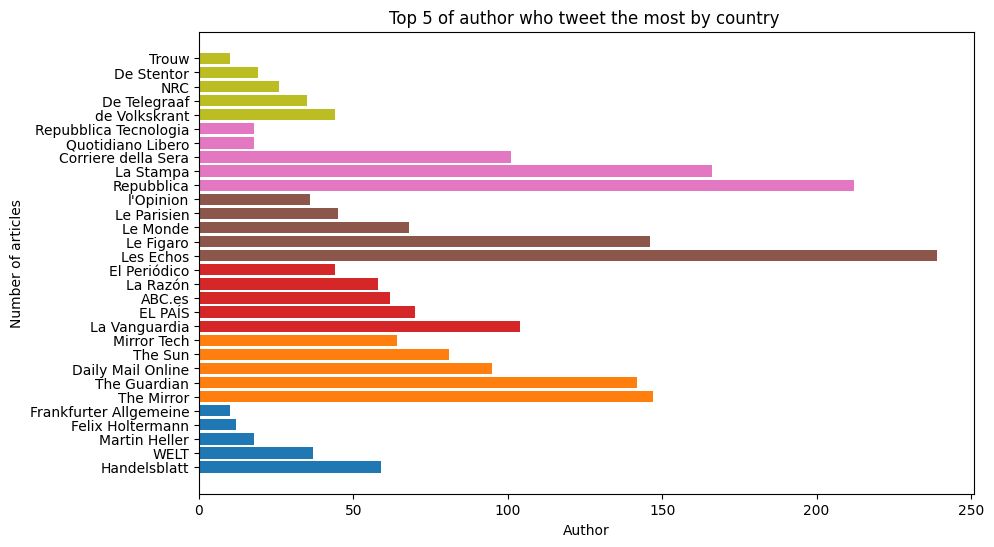

In [4]:

#modelize with a plot
fig, ax = plt.subplots(figsize=(10,6))
for i, (label, grp) in enumerate(top_5_by_label.groupby('label')):
    ax.barh(y=grp['author.name'], width=grp['id'], color=plt.cm.tab10(i / len(top_5_by_label['label'].unique())), label=label)

plt.xlabel("Author")
plt.ylabel("Number of articles")
plt.title("Top 5 of author who tweet the most by country ")
plt.show()



In [ ]:

#### The the distribution of tweets over time, by newspapers
data = var[['author.name', 'created_at', 'public_metrics.retweet_count']]

# Count the number of tweets by newspaper
tweet_counts = data.groupby(['author.name']).agg({'public_metrics.retweet_count': 'sum'}).reset_index()

# Select the top 10 newspapers with the most tweets
top_newspapers = tweet_counts.nlargest(10, 'public_metrics.retweet_count')['author.name'].tolist()

# Filter the data to keep only the top 10 newspapers
data = data[data['author.name'].isin(top_newspapers)]

# Group the data by newspaper and tweet year, and aggregate the number of tweets
data_by_newspaper = data.groupby(['author.name', dat['created_at'].dt.year]).agg({'public_metrics.retweet_count': 'sum'}).reset_index()

# Pivot the data to have one column for each newspaper, and one row for each year
pivoted_data = data_by_newspaper.pivot(index='created_at', columns='author.name', values='public_metrics.retweet_count').fillna(0)

In [ ]:
# Create a bar chart for each year
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("husl", len(top_newspapers)))
sns.set(rc={'figure.figsize':(12,8)})
pivoted_data.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of tweets')
plt.title('Number of tweets per year for the top 10 newspapers')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
# =============================================================================
# distribution of the 5 newspapers for each country by year
# =============================================================================
dat['created_at'] = pd.to_datetime(dat['created_at'])
dat['year'] = dat['created_at'].dt.year

count_by_author_and_label_and_year = dat.groupby(['year', 'author.name', 'label'])['id'].count().reset_index().sort_values(['label', 'year', 'id'], ascending=[True, True, False])

# Top 5 of authors by country over time
top_5_by_label_and_year = count_by_author_and_label_and_year.groupby(['label', 'year']).head(5)

# Graph specifications
for label, grp in top_5_by_label_and_year.groupby('label'):
    fig, ax = plt.subplots(figsize=(10,6))
    for i, (year, year_grp) in enumerate(grp.groupby('year')):
        ax.bar(year_grp['author.name'], year_grp['id'], color=plt.cm.tab10(i / len(grp['year'].unique())), label=year)
    plt.xlabel('Auteur')
    plt.ylabel("Nombre d'articles")
    plt.title(f"Top 5 of authors who tweets the most by country")
    plt.legend()
    plt.show()
  
##### Graph with the number of tweets by country by year 

var['year'] = pd.DatetimeIndex(var['created_at']).year

# Sort of tweets by country over time
tweets_by_country_year = var.groupby(['year', 'label']).size().reset_index(name='count')

# Graph specifications
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("pastel"))
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x="year", y="count", hue="label", data=tweets_by_country_year,
            palette=sns.color_palette("husl", len(tweets_by_country_year['label'].unique())))
plt.xlabel('Year')
plt.ylabel("Number of tweets")
plt.title("Number of tweets by country by year")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#### Like by followers

In [ ]:
# =============================================================================
# like by followers
# =============================================================================

# Compute the number of followers
var['likes_per_follower'] = var['public_metrics.like_count'] / var['author.public_metrics.followers_count']
top_journals_by_country = var.groupby(['label', 'author.name'])['likes_per_follower'].mean().groupby('label', group_keys=False).nlargest(5)
print(top_journals_by_country)

dat['author.name'].unique()
var['created_at'] = pd.to_datetime(var['created_at'])

# New colomn for the year and the month
var['year'] = var['created_at'].dt.year
var['month'] = var['created_at'].dt.month

# Merge DataFrames var et top_journals_by_country
merged_data = var.merge(top_journals_by_country, on=['author.name', 'label'])

# Graph specifications
plt.figure(figsize=(12, 6))
sns.barplot(x='year', y='public_metrics.like_count', hue='month', data=merged_data, ci=None, palette='Set3')
plt.xlabel('year')
plt.ylabel('Number of Like')
plt.title('Distribution of Likes byyear and month for the most important newspapers')
plt.xticks(rotation=45)
plt.show()


####like by newspapers by country by newspaper
data = dat[['public_metrics.like_count', 'author.name', 'label', 'created_at']]

# Compute the number of retweets by year, newpapers and countries
count_by_year_author_label = data.groupby(['label', 'author.name', dat['created_at'].dt.year])['public_metrics.like_count'].sum().reset_index()

# Select newspapers which tweet the most
top_author_per_label = count_by_year_author_label.loc[count_by_year_author_label.groupby('label')['public_metrics.retweet_count'].idxmax()]

#Merge data to select only the top newspapers
merged_data = pd.merge(data, top_author_per_label[['author.name', 'label']], on=['author.name', 'label'], how='inner')

# Graph specifications
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("husl", len(top_author_per_label['label'].unique())))
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x=merged_data['created_at'].dt.year, y=merged_data['public_metrics.like_count'], hue=merged_data['author.name'], palette='husl', ci=None)
plt.xlabel('Année')
plt.ylabel('Nombre de retweets')
plt.title('Distribution des like par année pour chaque journal qui tweet le plus par pays')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


####Number of like by year and country
data = dat[['public_metrics.like_count', 'author.name', 'label', 'created_at']]

# Compute number of retweets by year, newspapers and country
count_by_year_author_label = data.groupby(['label', 'author.name', dat['created_at'].dt.year])['public_metrics.like_count'].sum().reset_index()

# Select the newspapers which post the most by country
top_author_per_label = count_by_year_author_label.loc[count_by_year_author_label.groupby('label')['public_metrics.like_count'].idxmax()]

# Merge to keep only newspapers select
merged_data = pd.merge(data, top_author_per_label[['author.name', 'label']], on=['author.name', 'label'], how='inner')

# Graph specifications
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("husl", len(top_author_per_label['label'].unique())))
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x=merged_data['created_at'].dt.year, y=merged_data['public_metrics.like_count'], hue=merged_data['author.name'], palette='husl', ci=None)
plt.xlabel('Année')
plt.ylabel('Nombre de retweets')
plt.title('Distribution des like par année pour chaque journal qui tweet le plus par pays')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



#### Retweet

In [ ]:
### Number of retweets by year and country
data = dat[['created_at', 'public_metrics.retweet_count', 'label']]
data['created_at'] = pd.to_datetime(data['created_at'])
data['year'] = data['created_at'].dt.year

# Compute the number of retweets by year and by country
count_by_year_label = data.groupby(['label', 'year'])['public_metrics.retweet_count'].sum().reset_index()

# Graph
sns.set_style("whitegrid")
sns.set_palette("husl")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='year', y='public_metrics.retweet_count', hue='label', data=count_by_year_label)
plt.xlabel('Année')
plt.ylabel('Number of retweets')
plt.title('Number of retweets by year and by country')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


### Number of retweet by year by newspaper in each country 
data = dat[['public_metrics.retweet_count', 'author.name', 'label', 'created_at']]

# Compute the number of retweets by year, newspapers and by country
count_by_year_author_label = data.groupby(['label', 'author.name', dat['created_at'].dt.year])['public_metrics.retweet_count'].sum().reset_index()

# Select newspapers which tweet the most
top_author_per_label = count_by_year_author_label.loc[count_by_year_author_label.groupby('label')['public_metrics.retweet_count'].idxmax()]

#Merge for newspapers select
merged_data = pd.merge(data, top_author_per_label[['author.name', 'label']], on=['author.name', 'label'], how='inner')

# Graph
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("husl", len(top_author_per_label['label'].unique())))
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x=merged_data['created_at'].dt.year, y=merged_data['public_metrics.retweet_count'], hue=merged_data['author.name'], palette='husl', ci=None)
plt.xlabel('Année')
plt.ylabel('Nombre de retweets')
plt.title('Distribution des retweets par année pour chaque journal qui tweet le plus par pays')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


#### Extract hashtags from the tweet text

In [10]:
var = pd.DataFrame(var)

# Function which extract the hashtags (form "#")
def extract_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    return hashtags

#Create a new column where we apply the function
var['hashtags'] = var['text'].apply(extract_hashtags)

print(var)

                       id                created_at  \
0     1075677468294635522  2018-12-20T09:01:08.000Z   
1      670304079214702592  2015-11-27T18:12:00.000Z   
2     1085566226116628480  2019-01-16T15:55:31.000Z   
3      968059526594420736  2018-02-26T09:45:51.000Z   
4      784508641508483072  2016-10-07T21:40:10.000Z   
...                   ...                       ...   
2995   363143812530466816  2013-08-02T03:46:46.000Z   
2996  1044181853312176130  2018-09-24T11:08:48.000Z   
2997   788069634599587840  2016-10-17T17:30:17.000Z   
2998   880863441908625408  2017-06-30T18:59:44.000Z   
2999   720610688255795200  2016-04-14T13:52:31.000Z   

                                                   text  author.id  \
0     rt @gamecentral: borderland 2 vr rough ready w...  138749160   
1     'the world's sexiest robot'... apparently http...   34655603   
2     un antepasado del que sabiamos nada #ciencia #...   38640768   
3     im neuen #porsche "mission e" steckt die block...   5

## Data Analysis

### Apply Name Entity Recognition (NER) to identify key entities in the tweets.

In [13]:
nlp = spacy.load("en_core_web_sm")
tweets = var['text']
tweet_entities = []
for tweet in tweets:
    doc = nlp(tweet)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    tweet_entities.append(entities)

# Add the extracted entities to your DataFrame
var['tweet_entities'] = tweet_entities
print(var.head())


                    id                created_at  \
0  1075677468294635522  2018-12-20T09:01:08.000Z   
1   670304079214702592  2015-11-27T18:12:00.000Z   
2  1085566226116628480  2019-01-16T15:55:31.000Z   
3   968059526594420736  2018-02-26T09:45:51.000Z   
4   784508641508483072  2016-10-07T21:40:10.000Z   

                                                text  author.id  \
0  rt @gamecentral: borderland 2 vr rough ready w...  138749160   
1  'the world's sexiest robot'... apparently http...   34655603   
2  un antepasado del que sabiamos nada #ciencia #...   38640768   
3  im neuen #porsche "mission e" steckt die block...   53023065   
4  tweede wereldoorlog virtual reality herbeleven...   14702725   

         author.name  author.public_metrics.followers_count  \
0              Metro                                 357471   
1            The Sun                                2008106   
2  La Voz de Galicia                                 402899   
3        Lars Ophüls            

### Perform Sentiment Analysis to evaluate newspaper sentiment towards this technologies.

### Define a function to perform sentiment analysis

In [14]:
def analyze_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment analysis to the 'text' column
var['sentiment'] = var['text'].apply(analyze_sentiment)

### Translate tweets

In [ ]:
tr = Translator()

# Creating a progression bar
progress_bar = tqdm(total=len(var), desc="Translation Progress")

for i, row in var.iterrows():
    if row["label"] != "en":
        translated_text = None
        retries = 3  # Number of times to retry the translation
        while retries > 0:
            try:
                translation = tr.translate(row["text"], dest='en')
                if translation.text is not None:
                    translated_text = translation.text
                    break  # Translation successful, exit the loop
            except Exception as e:
                print(f"Error translating row {i}: {e}")
                retries -= 1
                time.sleep(2)  # Wait for a moment before retrying

        if translated_text is not None:
            var.at[i, "text"] = translated_text

    progress_bar.update(1)

progress_bar.close()

### Utilize Zero-Shot Classification to categorize tweets into predefined or dynamically identified topics.

In [ ]:
progress_bar = tqdm(total=len(var), desc="Topics Progress")

from transformers import pipeline

# Load a zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# List of topics or categories
topics = ["AI", "Robot", "VR", "5g", "IoT"]

# Create an empty list to store the predicted topics
predicted_topics = []

# Loop through each tweet
for text in var["text"]:
    # Perform zero-shot classification
    result = classifier(text, topics)

    # Extract the most likely label
    predicted_topic = result['labels'][0]
    
    # Append the predicted topic to the list
    predicted_topics.append(predicted_topic)

# Add the predicted topics to your DataFrame
var['predicted_topic'] = predicted_topics

progress_bar.update(1)

progress_bar.close()